## Importações

In [123]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings("ignore")

np.random.seed(777)

## Funções Principais

In [124]:
def prepare_train(path: str, selector) -> list:
    df_train = pd.read_csv(path)
    X_train = df_train.loc[:, df_train.columns != 'Target']
    y_train = df_train['Target']

    X_train = selector.fit_transform(X_train, y_train)
    return X_train, y_train


def prepare_test(path: str, selector) -> list:
    df_test = pd.read_csv(path)
    X_test = df_test.loc[:, df_test.columns != 'Target']
    y_test = df_test['Target']

    X_test = selector.transform(X_test)
    return X_test, y_test


def get_best_clf(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

    scorer = make_scorer(f1_score, pos_label='Dropout')
    cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring=scorer)
    scorer = make_scorer(accuracy_score)
    accuracy_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring=scorer)

    print(f'Scores de F1 para cada fold: {cv_scores}')
    print(f'Média do F1-score: {cv_scores.mean()}')
    print(f'Desvio padrão do F1-score: {cv_scores.std()}')
    print(f'Acurácia para cada fold: {accuracy_scores}')
    print(f'Média das acurácias: {accuracy_scores.mean()}')

    best_clf.fit(X_train, y_train)

    print("Melhores hiperparâmetros encontrados:")
    print(grid_search.best_params_)

    f1 = cv_scores.mean()

    return best_clf, f1


def print_clf_score(best_clf, X_test, y_test):
    y_pred = best_clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=['Dropout', 'Graduate_or_Enrolled'])
    labels = ['Dropout', 'Graduate_or_Enrolled']

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='summer')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.xticks(np.arange(len(labels)) + 0.5, labels)
    plt.yticks(np.arange(len(labels)) + 0.5, labels)
    plt.show()


def dump_model(best_clf, model_path, X_test, y_test, f1):
    y_pred = best_clf.predict(X_test)
    a = accuracy_score(y_test, y_pred)
    joblib.dump(best_clf, f'{model_path}a{int(100*a)}_f{int(100*f1)}.pkl')

In [125]:
train_path = '../data/preprocessed/train-validation/'
test_path = '../data/preprocessed/test/'
models_path = '../models-dump/'

## Naive Bayes

### Padrão

In [126]:
data_config = 'drp_XOHE_scld.csv'

clf = MultinomialNB()

selector = SelectKBest(score_func=f_classif, k=60)

X_train, y_train = prepare_train(train_path+data_config, selector)

param_grid = {
    'alpha': [.1, 1, 5, 10, 1000]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

#X_test, y_test = prepare_test(test_path+data_config, selector)

#print_clf_score(best_clf, X_test, y_test)

#dump_model(best_clf, models_path+'naive-bayes/', X_test, y_test, f1)

Scores de F1 para cada fold: [0.53488372 0.58468677 0.61611374 0.61784897 0.53395785]
Média do F1-score: 0.5774982111266058
Desvio padrão do F1-score: 0.037101959021217934
Acurácia para cada fold: [0.71751412 0.74717514 0.77118644 0.76412429 0.718529  ]
Média das acurácias: 0.7437057991513437
Melhores hiperparâmetros encontrados:
{'alpha': 0.1}


### Rebalanceado

In [127]:
data_config = 'drp_XOHE_scld.csv'

clf = MultinomialNB()

selector = SelectKBest(score_func=f_classif, k=60)

X_train, y_train = prepare_train(train_path+'rebalanced/'+data_config, selector)

param_grid = {
    'alpha': [.1, 1, 5, 10, 1000]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

#X_test, y_test = prepare_test(test_path+data_config, selector)

#print_clf_score(best_clf, X_test, y_test)

#dump_model(best_clf, models_path+'naive-bayes/', X_test, y_test, f1)

Scores de F1 para cada fold: [0.76517755 0.74885845 0.77375566 0.74941995 0.76415094]
Média do F1-score: 0.7602725098544798
Desvio padrão do F1-score: 0.009684582413132978
Acurácia para cada fold: [0.76651481 0.74914481 0.77194983 0.75370582 0.77194983]
Média das acurácias: 0.7626530182881692
Melhores hiperparâmetros encontrados:
{'alpha': 0.1}


## DTREE

### Padrão

In [128]:
data_config = 'drp_XOHE_scld.csv'

clf = DecisionTreeClassifier()

selector = SelectKBest(score_func=f_classif, k=60)

X_train, y_train = prepare_train(train_path+data_config, selector)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

#X_test, y_test = prepare_test(test_path+data_config, selector)

#print_clf_score(best_clf, X_test, y_test)

#dump_model(best_clf, models_path+'decision-tree/', X_test, y_test, f1)

Scores de F1 para cada fold: [0.765      0.75846501 0.77832512 0.73348519 0.74185464]
Média do F1-score: 0.7554259929305476
Desvio padrão do F1-score: 0.016067655684959863
Acurácia para cada fold: [0.86723164 0.84887006 0.87288136 0.83474576 0.85148515]
Média das acurácias: 0.8550427924148346
Melhores hiperparâmetros encontrados:
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


### Rebalanceado

In [129]:
data_config = 'drp_XOHE_scld.csv'

clf = DecisionTreeClassifier()

selector = SelectKBest(score_func=f_classif, k=60)

X_train, y_train = prepare_train(train_path+'rebalanced/'+data_config, selector)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

#X_test, y_test = prepare_test(test_path+data_config, selector)

#print_clf_score(best_clf, X_test, y_test)

#dump_model(best_clf, models_path+'decision-tree/', X_test, y_test, f1)

Scores de F1 para cada fold: [0.87868852 0.88288288 0.89309577 0.87336245 0.86101695]
Média do F1-score: 0.8778093140829203
Desvio padrão do F1-score: 0.010601395730642138
Acurácia para cada fold: [0.87357631 0.88141391 0.89053592 0.8677309  0.85974914]
Média das acurácias: 0.8746012368734789
Melhores hiperparâmetros encontrados:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Logistic Regression

### Padrão

In [130]:
data_config = 'drp_XOHE_scld.csv'

clf = LogisticRegression()

selector = SelectKBest(score_func=f_classif, k=60)

X_train, y_train = prepare_train(train_path+data_config, selector)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None, {
        'Dropout': 2,
        'Graduate_or_Enrolled': 1
    }],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky']
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

#X_test, y_test = prepare_test(test_path+data_config, selector)

#print_clf_score(best_clf, X_test, y_test)

#dump_model(best_clf, models_path+'logistic-regression/', X_test, y_test, f1)

Scores de F1 para cada fold: [0.80092593 0.75990676 0.78486998 0.76009501 0.73123487]
Média do F1-score: 0.7674065081793191
Desvio padrão do F1-score: 0.02386049424184817
Acurácia para cada fold: [0.87853107 0.85875706 0.86864407 0.85734463 0.84299859]
Média das acurácias: 0.861255084346207
Melhores hiperparâmetros encontrados:
{'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


### Rebalanceado

In [131]:
data_config = 'drp_XOHE_scld.csv'

clf = LogisticRegression()

selector = SelectKBest(score_func=f_classif, k=60)

X_train, y_train = prepare_train(train_path+'rebalanced/'+data_config, selector)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None, {
        'Dropout': 2,
        'Graduate_or_Enrolled': 1
    }],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky']
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

Scores de F1 para cada fold: [0.8758465  0.86887115 0.86987104 0.85290764 0.85035629]
Média do F1-score: 0.8635705260751795
Desvio padrão do F1-score: 0.010067827717102882
Acurácia para cada fold: [0.87357631 0.86659065 0.87343216 0.85632839 0.85746864]
Média das acurácias: 0.8654792300319738
Melhores hiperparâmetros encontrados:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


## Testando melhor modelo e armazenando

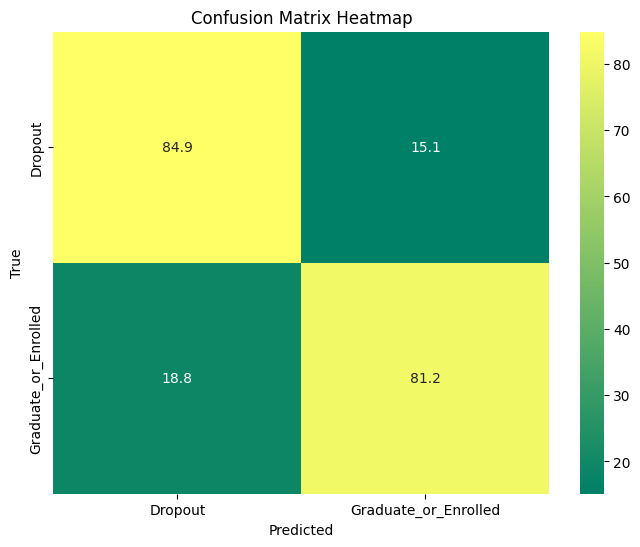

In [132]:
X_test, y_test = prepare_test(test_path+data_config, selector)

print_clf_score(best_clf, X_test, y_test)

dump_model(best_clf, models_path+'logistic-regression/', X_test, y_test, f1)

## Carregando melhor modelo

In [133]:
loaded_clf = joblib.load(f'{models_path}logistic-regression/a82_f86.pkl')

# Avaliar o modelo carregado
print("Acurácia do melhor modelo no conjunto de teste:", loaded_clf.score(X_test, y_test))

Acurácia do melhor modelo no conjunto de teste: 0.823728813559322
